<a href="https://colab.research.google.com/github/cpedebos/EGB-MC15/blob/main/Martini%2Bcg2all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations of protein systems using OpenMM engine and Martini force field. This notebook is a supplementary material of the paper "***Making it rain: Cloud-based molecular simulations for everyone***" ([link here](https://doi.org/10.1021/acs.jcim.1c00998)) and we encourage you to read it before using this pipeline.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to run microsecond-long coarse-grained MD simulations in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for MD simulations!** It is just simple MD pipeline illustrating each step of a simulation protocol.

---
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/making-it-rain/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Martini](http://cgmartini.nl/index.php) team for their amazing  work in the coarse-grained force fields.

- We would like to thank [Paulo C. T. Souza ](https://twitter.com/SouzaPauloCT),  [Justin L. MacCallum](https://twitter.com/jlmaccal), [Valentina Corradi](https://www.ucalgary.ca/biocomputing/vcorradi) and [D. Peter Tieleman](https://live-ucalgary.ucalgary.ca/biocomputing/tieleman) for their work in the Martini3 force field and for the implementation of Martini in OpenMM.

-  We would like to thank [Feig lab Team](https://feig.bch.msu.edu/) for his incredible [cg2all](https://www.biorxiv.org/content/10.1101/2023.05.22.541652v1).

- A Making-it-rain by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/making-it-rain)

# **Introduction**

In general, MD simulations rely on 1) a set of atomic coordinates of all atoms on a simulation box and 2) a set of force field parameters that describes the interaction energies between atoms.

In terms of MARTINI inputs, we wil need:
*  A PDB ID or a .pdb file containing a set of atomic coordinates of your molecule.

In this notebook, we will simulate PDB 1UBQ, a structure of ubiquitin. To build our simulation box, we will use martinize2, a tools for setting up starting structures for molecular dynamics (MD) simulations starting from atomistic coordinates, with a special focus on polymeric systems (including proteins and DNA). Martinize2 is a rewrite of Martinize. It is aimed at producing coarse-grained structures and topologies from an atomistic structure. Here, we will use [Vermouth](https://github.com/marrink-lab/vermouth-martinize) (VERsatile, MOdular, and Universal Tranformation Helper), a python library that powers Martinize2. It allows to describe and apply transformation on molecular structures and topologies using graph algorithms.
## ---







---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol)
5.    Numpy (https://numpy.org)
6.    Matplotlib (https://matplotlib.org)
7.    AmberTools (https://ambermd.org/AmberTools.php)
8.    MDAnalysis (https://www.mdanalysis.org)
9.    Vermouth (https://github.com/marrink-lab/vermouth-martinize)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
%%capture

import sys
import tarfile
import os
import subprocess
import sys

commands = [
    "mamba install -c conda-forge ambertools -y",
    "pip install git+https://github.com/pablo-arantes/biopandas",
    "mamba install openmm",
    "pip install --upgrade MDAnalysis",
    "pip install vermouth",
    "pip install git+https://github.com/pablo-arantes/martini_openmm",
    "pip install git+https://github.com/Tsjerk/simopt",
    "pip install git+https://github.com/pablo-arantes/Insane",
    "pip install py3Dmol",
    "mamba install -c conda-forge mdtraj",
    "pip install biopython"
]

for cmd in commands:
    subprocess.run(cmd, shell=True)

os.system("npx degit https://github.com/pablo-arantes/Making-it-rain/ temp")
os.system("cp -r temp/martini .")
os.system("rm -r temp")


#load dependencies
import sys
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
import subprocess
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title **Install dependencies for cg2all**
#@markdown **cg2all** is a novel deep-learning model capable of efficiently predicting all-atom protein structures from coarse-grained (CG) representations.

#@markdown It will take around 4-5 minutes, please, continue your coffee and wait. ;-)
# install dependencies

%%capture
%%bash
mamba create --name cg2all pip cudatoolkit=11.3 dgl=1.0 -c dglteam/label/cu113
source activate cg2all
pip install git+http://github.com/huhlim/cg2all

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 16 00:47:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**Important**: You can submit your own PDB file, make sure the PDB file points to the correct structure. Please type the entire file name, i.e. file.pdb

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e. MyDrive/protein_martini and so on.**


In [ ]:
#@title **Please, provide the necessary input below:**
%%capture
Google_Drive_Path = '/content/drive/MyDrive/CG_EGB' #@param {type:"string"}
workDir = Google_Drive_Path

if os.path.exists(os.path.join(workDir)):
  pass
else:
  os.system("mkdir " + str(workDir))

foldername = 'martini'
top_folder = os.path.join(workDir, str(foldername))
top_folder_check = os.path.exists(top_folder)
if top_folder_check == False:
  os.system("cp -r ./martini " + str(workDir))
else:
  pass

Own_PDB = "no" #@param ["yes", "no"]

PDB_ID_or_filename = '1UBQ' #@param {type:"string"}


if Own_PDB == "no":
  pdbfn = PDB_ID_or_filename + ".pdb"
  pdbfn = PDB_ID_or_filename + ".pdb"
  url = 'https://files.rcsb.org/download/' + pdbfn
  outfnm = os.path.join(workDir, pdbfn)
  urllib.request.urlretrieve(url, outfnm)
else:
  outfnm = os.path.join(workDir, PDB_ID_or_filename)

import numpy as np
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry.hbond import _prep_kabsch_sander_arrays
from mdtraj.geometry import _geometry
# if PY2:
#     from string import maketrans
# else:
maketrans = str.maketrans

SIMPLIFIED_CODE_TRANSLATION = maketrans('HGIEBTS ', 'HHHEECCC')
__all__ = ['compute_dssp']

def compute_dssp(traj, simplified=True):
    """Compute Dictionary of protein secondary structure (DSSP) secondary structure assignments
    Parameters
    ----------
    traj : md.Trajectory
        A trajectory
    simplified : bool, default=True
        Use the simplified 3-category assignment scheme. Otherwise the original
        8-category scheme is used.
    Returns
    -------
    assignments : np.ndarray, shape=(n_frames, n_residues), dtype=S1
        The assignments is a 2D array of character codes (see below), giving
        the secondary structure of each residue in each frame.
    Notes
    -----
    The DSSP assignment codes are:
       - 'H' : Alpha helix
       - 'B' : Residue in isolated beta-bridge
       - 'E' : Extended strand, participates in beta ladder
       - 'G' : 3-helix (3/10 helix)
       - 'I' : 5 helix (pi helix)
       - 'T' : hydrogen bonded turn
       - 'S' : bend
       - ' ' : Loops and irregular elements
    The simplified DSSP codes are:
       - 'H' : Helix. Either of the 'H', 'G', or 'I' codes.
       - 'E' : Strand. Either of the 'E', or 'B' codes.
       - 'C' : Coil. Either of the 'T', 'S' or ' ' codes.
    A special 'NA' code will be assigned to each 'residue' in the topology which
    isn't actually a protein residue (does not contain atoms with the names
    'CA', 'N', 'C', 'O'), such as water molecules that are listed as 'residue's
    in the topology.
    Our implementation is based on DSSP-2.2.0, written by Maarten L. Hekkelman
    and distributed under the Boost Software license.
    References
    ----------
    .. [1] Kabsch W, Sander C (1983). "Dictionary of protein secondary
       structure: pattern recognition of hydrogen-bonded and geometrical
       features". Biopolymers 22 (12): 2577-637. doi:10.1002/bip.360221211
    """
    if traj.topology is None:
        raise ValueError('kabsch_sander requires topology')

    xyz, nco_indices, ca_indices, proline_indices, protein_indices \
        = _prep_kabsch_sander_arrays(traj)
    chain_ids = np.array([r.chain.index for r in traj.top.residues], dtype=np.int32)

    value = _geometry._dssp(xyz, nco_indices, ca_indices, proline_indices, chain_ids)
    if simplified:
        value = value.translate(SIMPLIFIED_CODE_TRANSLATION)

    n_frames = xyz.shape[0]
    n_residues = nco_indices.shape[0]
    # if PY2:
    #     array = np.fromiter(value, dtype=np.dtype('S2'))
    # else:
    array = np.fromiter(value, dtype=np.dtype('U2'))

    array = array.reshape(n_frames, n_residues)
    array[:, np.logical_not(protein_indices)] = 'NA'
    return array

# remove_waters = "yes" #@param ["yes", "no" ]
# if remove_waters == "yes":
#   no_waters = "nowat"
# else:
#   no_waters = ''

starting = os.path.join(workDir, "starting.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());



pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)


pdb_ss = md.load_pdb(starting2)
ss = compute_dssp(pdb_ss, simplified=True,)

my_string = ''.join([str(item) for sublist in ss for item in sublist])
# print("Secondary Structure = " + str(my_string))

#@markdown ---

In [ ]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "rainbow" #@param ["gray", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_box = True #@param {type:"boolean"}
opacity = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}

def show_pdb(show_sidechains=False, show_mainchains=False, show_box = False, color="rainbow"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(starting2,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PW"}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': opacity, 'color':'white'})
  view.zoomTo()
  return view

print("Secondary Structure = " + str(my_string))
show_pdb(show_sidechains, show_mainchains, show_box, color).show()

Secondary Structure = CEEEEEECCCCEEEEECCCCCEHHHHHHHHHHHHCCCHHHEEEEECCEECCCCCECHHHCCCCCCEEEEEECCCCC


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Parameters to generate the Martini topology:**
import glob

top_martini = os.path.join(workDir, "martini.top")
top_temp = os.path.join(workDir, "martini_temp.top")
gro_martini = os.path.join(workDir, "system.gro")
pdb_nw_martini = os.path.join(workDir, "martini.pdb")
pdb_martini = os.path.join(workDir, "ions.pdb")

force_field = "martini3001" #@param ["martini3001", "martini22"]
#@markdown Position Restraints:
position_restraints = "backbone" #@param ["none","all","backbone"]
#@markdown Position restraints force constant in kJ/mol (default: 1000):
posres_force = 1000 #@param {type:"slider", min:0, max:2000, step:100}
secondary_structure_handling = "yes" #@param ["yes","no"]
if secondary_structure_handling == "yes":
  ss_h = my_string
else:
  ss_h = ''

#@markdown Protein elastic network:
write_elastic_bonds = "True" #@param ["True","False"]
#@markdown Elastic bond force constant Fc in kJ/mol (default: 500):
elastic_force = 500 #@param {type:"slider", min:0, max:2000, step:100}
#@markdown Elastic bond lower cutoff (default: 0):
elastic_lower = 0 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown Elastic bond upper cutoff (default: 0.9):
elastic_upper = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
if write_elastic_bonds == "True":
  elastic = " -elastic -ef " + str(elastic_force) + " -el " + str(elastic_lower) + " -eu " + str(elastic_upper)
else:
  elastic = ''

side_chain_corrections = "yes" #@param ["yes","no"]
if side_chain_corrections == "yes":
  scfix = " -scfix"
else:
  scfix = ''
cystein_bonds = "yes" #@param ["yes","no"]
if cystein_bonds == "yes":
  cys = "auto"
else:
  cys = "none"

if os.path.exists(top_martini):
  os.remove(top_martini)
  os.remove(gro_martini)
  os.remove(pdb_nw_martini)
else:
  pass

folder_workdir = "cd " + str(workDir)
martinize2 = "martinize2 -f " + str(starting2) + " -x " + str(pdb_nw_martini)  + " -ss " + str(ss_h) + " -ff " + str(force_field) +  str(elastic) + " -p " + str(position_restraints) +  " -pf " + str(posres_force) + " -cys " + str(cys) + str(scfix) +  " -o " + str(top_martini) + " -maxwarn 10 -ignh"

original_stdout = sys.stdout # Save a reference to the original standard output
with open('martinize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(folder_workdir)
    print(martinize2)
    sys.stdout = original_stdout # Reset the standard output to its original value

os.system("chmod 700 martinize.sh")
os.system("bash martinize.sh")

#@markdown **Parameters to solvate the system:**

box_type = "cubic" #@param ["square", "cubic", "optimal"]

#@markdown Minimum distance from the protein to box edge (nm):

size_box = 1.5 #@param {type:"slider", min:0, max:10, step:0.1}

#@markdown **ATTENTION**: Give the concentration in Molar units (NaCl):

Concentration = 0.15 #@param {type:"slider", min:0, max:2, step:0.01}

os.system("insane -o " + str(gro_martini) + " -p " + str(top_temp) + " -f "  + str(pdb_nw_martini) + " -d " + str(size_box) + " -sol W -salt " + str(Concentration) + " -charge auto -pbc " + str(box_type))

with open(top_martini, 'r') as f:
    lines = f.readlines()
# Remove the first line
lines.pop(0)
lines.pop(0)
if force_field == "martini3001":
  new_lines = ['#include "martini/martini_v3.0.0.itp"\n', '#include "martini/martini_v3.0.0_ions.itp"\n', '#include "martini/martini_v3.0.0_solvents.itp"\n']
elif force_field == "martini22":
  new_lines = ['#include "martini/martini_v2.2.itp"\n', '#include "martini/martini_v2.2_ions.itp"\n', '#include "martini/martini_v2.2_aminoacids.itp"\n']
else:
  pass
lines = new_lines + lines
# Write the updated content back to the file
with open(top_martini, 'w') as f:
    f.writelines(lines)


if Concentration == 0:
  with open(top_temp, "r") as file:
    lines = file.readlines()
  last_line = lines[-1].split()
  if last_line[0] == "W":
      with open(top_temp) as f_in, open(top_martini, "a") as f_out :
        for row in f_in.readlines()[-1:] :
          f_out.write(row)
  else:
      with open(top_temp) as f_in, open(top_martini, "a") as f_out :
        for row in f_in.readlines()[-2:] :
          f_out.write(row)
else:
  with open(top_temp) as f_in, open(top_martini, "a") as f_out :
      for row in f_in.readlines()[-3:] :
          f_out.write(row)

universe = mda.Universe(gro_martini)
with mda.Writer(pdb_martini) as pdb:
  pdb.write(universe)

os.system("rm " + str(workDir) + "/*#")
os.remove(top_temp)

gro_check = os.path.exists(gro_martini)
top_check = os.path.exists(top_martini)

if gro_check == True and top_check == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your input file! ")

Successfully generated topology! :-)


## Let's take a look on our simulation box:

In [ ]:
#@title **Check your conversion to Martini**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol
show_waters = True #@param {type:"boolean"}
opacity = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}

if show_waters == False:
  input_file = pdb_nw_martini
else:
  input_file = pdb_martini

def show_pdb(color="rainbow"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(input_file,'r').read(),'pdb')
  view.setStyle({'sphere': {'color':'spectrum'}})
  view.addSurface(py3Dmol.SAS, {'opacity': opacity, 'color':'white'})
  view.zoomTo()
  return view

show_pdb(color).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system on NVT (first) and NPT ensembles.

In [ ]:
#@title ### **Parameters for MD Equilibration (NVT and NPT):**

# remove whitespaces
Jobname = '1UBQ' #@param {type:"string"}

Minimization_steps = "5000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

 #@markdown Integration time (in femtoseconds):
Integration_timestep = "20" #@param ["5", "10", "20", "30", "40"]
dt_eq = Integration_timestep

#@markdown Simulation time (in nanoseconds) for NVT equilibration:
Time = "5" #@param {type:"string"}
stride_time_eq_nvt = Time
#@markdown Simulation time (in nanoseconds) for NPT equilibration:
Time = "5" #@param {type:"string"}
stride_time_eq_npt = Time


#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = "298" #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

# #@markdown Position restraints force constant (in kJ/mol):
# Force_constant = 500 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectories files (in picoseconds):

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log

#@markdown ---


In [ ]:
#@title **Runs an Equilibration coarse-grained MD simulation (NVT and NPT ensembles)**
#@markdown Now, let's run our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import martini_openmm as martini
from mdtraj.reporters import XTCReporter
import pytraj as pt
import parmed
from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = os.path.join(workDir, "system.gro")
pdbfile = os.path.join(workDir, "ions.pdb")
topologyfile = os.path.join(workDir, "martini.top")

time_ps = float(stride_time_eq_nvt)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

# restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

# def restraints(system, crd, fc, restraint_array):

# 	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
# 	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
# 	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

# 	if fc > 0:
# 		# positional restraints for all heavy-atoms
# 		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
# 		posresPROT.addPerParticleParameter('k')
# 		posresPROT.addPerParticleParameter('x0')
# 		posresPROT.addPerParticleParameter('y0')
# 		posresPROT.addPerParticleParameter('z0')

# 		for atom1 in restraint_array:
# 			atom1 = int(atom1)

# 			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
# 			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
# 			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

# 			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

# 		system.addForce(posresPROT)

# 	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
#############################################

# get any defines
defines = {}
try:
	with open("defines.txt") as def_file:
		for line in def_file:
			line = line.strip()
			defines[line] = True
except FileNotFoundError:
	pass

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
gro = GromacsGroFile(coordinatefile)
top = martini.MartiniTopFile(topologyfile, periodicBoxVectors=gro.getPeriodicBoxVectors(), defines=defines)


print("\t- Creating system and setting parameters...")
friction = 10.0 / picosecond
system = top.create_system(nonbonded_cutoff=1.1*nanometer)

# print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
# pt_system = pt.iterload(coordinatefile, pdb)
# pt_topology = pt_system.top
# restraint_array = pt.select_atoms('!(:SOL) & !(:NA) & !(:CL) & !(:MG) & !(:K)', pt_topology)

# system = restraints(system, gro, restraint_fc, restraint_array)

# print("\t- Setting barostat...")
# system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setRandomNumberSeed(0)
# integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(top.topology, system, integrator)
simulation.context.setPositions(gro.positions)

parmed_structure = parmed.openmm.load_topology(top.topology, system, gro.positions)

parmed_structure.save(os.path.join(workDir, 'system_openMM.pdb'), overwrite=True)
with open(os.path.join(workDir, 'system_openMM.xml'), 'w') as output:
  output.write(XmlSerializer.serialize(system))

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=1.0, maxIterations=int(Minimization_steps))

print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NVT ensemble

dcd_file = jobname + "_eq_nvt.dcd"
log_file = jobname + "_eq_nvt.log"
rst_file_nvt = jobname + "_eq_nvt.rst"
prv_rst_file = jobname + "_eq_nvt.rst"
pdb_file = jobname + "_eq_nvt.pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file_nvt) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file_nvt, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))


#############################################
# Running Equilibration on NPT ensemble

time_ps = float(stride_time_eq_npt)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond
pressure	= float(pressure_eq)*bar

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

print("\tPressure = " + str(pressure))
print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\n> Loading previous state from equilibration > " + rst_file_nvt + " <")
with open(rst_file_nvt, 'r') as f:
	simulation.context.setState(XmlSerializer.deserialize(f.read()))
	currstep = int((1-1)*nsteps)
	currtime = currstep*dt.in_units_of(picosecond)
	simulation.currentStep = currstep
	simulation.context.setTime(currtime)
	print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

dcd_file = jobname + "_eq_npt.dcd"
log_file = jobname + "_eq_npt.log"
rst_file_npt = jobname + "_eq_npt.rst"
prv_rst_file = jobname + "_eq_npt.rst"
pdb_file = jobname + "_eq_npt.pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.

##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file_npt) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file_npt, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/drive/MyDrive/CG_EGB/1UBQ
	Coordinate file = /content/drive/MyDrive/CG_EGB/system.gro
	PDB file = /content/drive/MyDrive/CG_EGB/ions.pdb
	Topology file = /content/drive/MyDrive/CG_EGB/martini.top

	Simulation_time = 5000.0 ps
	Integration timestep = 20 fs
	Total number of steps = 250000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting integrator...
	- Energy minimization: 5000 steps
	-> Potential Energy = -62684.397888183594 kJ/mol
	- Setting initial velocities...

> Simulating 250000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
0.2%		500		0		--
0.4%		1000		1.73e+03		4:09
0.6%		1500		2.25e+03		3:10
0.8%		2000		2.95e+03		2:25
1.0%		2500		3.51e+03		2:01
1.2%		3000		4.03e+03		1:45
1.4%		3500		4.04e+03		1:45
1.6%		4000		3.57e+03		1:59
1.8%		4500		3.58e+03		1:58
2.0%		

---
---
# **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs.

In [ ]:
# Equilibrated_PDB = '1aki_equil.pdb' #@param {type:"string"}
# State_file = '1aki_equil.rst' #@param {type:"string"}

#@markdown ### **Parameters for MD Production protocol:**
#@markdown **Important**: The **Jobname** should be the same you have been used to run your simulation in the previous step.
Jobname = '1UBQ' #@param {type:"string"}

#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds):
Stride_Time = "20" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "5" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "20" #@param ["5", "10", "20", "30", "40"]

dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds):
Write_the_trajectory = "200" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

continue_simulation = "no" #@param ["yes", "no"]

#@markdown **Important:** If you are going to continue your simulation, all the parameters should be the same, including the **Jobname**. The only parameter you should change is the **Number of strides**, which you will increase.


#@markdown ---

In [ ]:
#@title **Runs a Production coarse-grained MD simulation (NPT ensemble) after equilibration**

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import martini_openmm as martini
from mdtraj.reporters import XTCReporter
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch
#############################################

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = os.path.join(workDir, "system.gro")
pdbfile = os.path.join(workDir, "ions.pdb")
topologyfile = os.path.join(workDir, "martini.top")

stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer

# get any defines
defines = {}
try:
	with open("defines.txt") as def_file:
		for line in def_file:
			line = line.strip()
			defines[line] = True
except FileNotFoundError:
	pass

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if continue_simulation == "yes":
	for i in range(1,int(nstride)+1):
		name = str(jobname) + "_" + str(i) + "_prod_npt.pdb"
		name2 = str(jobname) + "_" + str(i) + "_prod_npt.rst"
		if os.path.exists(name) and os.path.exists(name2):
			last_stride_pdb = name
			last_stride_rst = name2
		else:
			pass
	gro = PDBFile(last_stride_pdb)
	with open(os.path.join(workDir, 'system_openMM.xml')) as input:
  		system = XmlSerializer.deserialize(input.read())
	top = gro.getTopology()
else:
	top = top.topology

print("\t- Setting integrator...")
friction = 10.0 / picosecond
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setRandomNumberSeed(0)
simulation = Simulation(top, system, integrator)
simulation.context.setPositions(gro.positions)

print("\tPressure = " + str(pressure))
print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")
	rst_file_npt = jobname + "_eq_npt.rst"
	dcd_file = jobname + "_" + str(n) + "_prod_npt.dcd"
	log_file = jobname + "_" + str(n) + "_prod_npt.log"
	rst_file = jobname + "_" + str(n) + "_prod_npt.rst"
	prv_rst_file = jobname + "_" + str(n-1) + "_prod_npt.rst"
	pdb_file = jobname + "_" + str(n) + "_prod_npt.pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + rst_file_npt + " <")
		with open(rst_file_npt, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.

	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

Streaming output truncated to the last 5000 lines.
50.3%		2514500		8.01e+03		8:56
50.3%		2515000		8.01e+03		8:56
50.3%		2515500		8.01e+03		8:56
50.3%		2516000		8.01e+03		8:55
50.3%		2516500		8.01e+03		8:55
50.3%		2517000		8.01e+03		8:55
50.4%		2517500		8.01e+03		8:55
50.4%		2518000		8.01e+03		8:55
50.4%		2518500		8.01e+03		8:55
50.4%		2519000		8.01e+03		8:54
50.4%		2519500		8.01e+03		8:54
50.4%		2520000		8.02e+03		8:54
50.4%		2520500		8.02e+03		8:54
50.4%		2521000		8.02e+03		8:54
50.4%		2521500		8.02e+03		8:54
50.4%		2522000		8.02e+03		8:53
50.5%		2522500		8.02e+03		8:53
50.5%		2523000		8.02e+03		8:53
50.5%		2523500		8.02e+03		8:53
50.5%		2524000		8.02e+03		8:53
50.5%		2524500		8.02e+03		8:53
50.5%		2525000		8.02e+03		8:53
50.5%		2525500		8.02e+03		8:52
50.5%		2526000		8.02e+03		8:52
50.5%		2526500		8.02e+03		8:52
50.5%		2527000		8.03e+03		8:52
50.5%		2527500		8.03e+03		8:52
50.6%		2528000		8.03e+03		8:52
50.6%		2528500		8.03e+03		8:52
50.6%		2529000		8.03e+03		8:51
50.6%		2529500		8.0

In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps.

#@markdown The code will save two trajectories: One with waters and other without waters.
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/drive/MyDrive/CG_EGB' #@param {type:"string"}
workDir = Google_Drive_Path
Jobname = "1UBQ" #@param {type: "string"}
# force_field = "martini3001" #@param ["martini22p", "martini3001", "martini22"]
Equilibrated_PDB = Jobname + "_eq_npt.pdb"
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
# Output_format = "dcd" #["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "5" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "20" #@param {type:"string"}
trajectory_saved_frequency = "200" #@param ["10", "100", "200", "500", "1000"]
Write_trajectory = trajectory_saved_frequency
traj_save_freq = trajectory_saved_frequency
# Remove_waters = "no" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
# output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)

nw_dcd = os.path.join(workDir, str(Jobname) + "_cg_nw.dcd")
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
backmap_dcd = os.path.join(workDir, str(Jobname) + "_100_frames_nw.dcd")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
whole_dcd = os.path.join(workDir, str(Jobname) +  "_cg_whole.dcd")
template =  os.path.join(workDir, str(Jobname) + '_%s_prod_npt.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

# if force_field == "martini3001":
#   mask_mda = "not (resname W or name NA+ or name CL-)"
# elif force_field == "martini22":
#   mask_mda = "not (resname W or name NA+ or name CL-)"
# else:
#   pass

mask_mda = "not (resname W or name NA+ or name CL-)"

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(pdb, flist)
u2 = mda.Universe(pdb, ref)

num_frames = len(u1.trajectory)
if num_frames >= 10:
  stride_backmapping = num_frames/10
else:
  "ATTENTION: You need at least 100 frames to proceed, please increase your MD simulation time."

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select=mask_mda, in_memory=True).run()

nw = u1.select_atoms(mask_mda)

#Remove the Waters
with mda.Writer(nw_dcd, nw.n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(nw, )
not_waters = u2.select_atoms(mask_mda)
not_waters.write(nw_pdb)
traj_dcd_check = os.path.exists(nw_dcd)
traj = nw_dcd
pdb_ref = nw_pdb
#For Backmapping
# with mda.Writer(backmap_dcd, nw.n_atoms) as W:
#   for ts in u1.trajectory[::int(stride_backmapping)]:
#   # for ts in u1.trajectory[0:100:int(1)]:
#       W.write(nw, )
#keep the waters
with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(u1.select_atoms("all"))
whole = u2.select_atoms("all")
whole.write(whole_pdb)
traj_dcd_check = os.path.exists(whole_dcd)
  # traj = whole_dcd
  # pdb_ref = whole_pdb

traj_load_cg = pt.load(traj, pdb_ref)
print(traj_load_cg)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 500 frames: 
Size: 0.001855 (GB)
<Topology: 166 atoms, 76 residues, 166 mols, PBC with box type = cubic>
           
Trajectory concatenated successfully! :-)


In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('all')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"sphere": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Back-mapping**

Here we are going to use a general approach to transforming molecular models between different levels of resolution, based on machine learning methods. To perform this transformation we will use the [cg2all](https://www.biorxiv.org/content/10.1101/2023.05.22.541652v1) code.

In [ ]:
#@title Conversion of a CG simulation trajectory to an atomistic simulation trajectory using [__convert_cg2all__](https://github.com/huhlim/cg2all/tree/main)
#@markdown Back-map a coarse-grained model (trajectory) to a finer level of representation (atomistic).

#@markdown This step will take a few minutes. it will be proportional to the number of frames you have in your final coarse-grained trajectory.


%%capture
%%bash

source activate cg2all
python
import cg2all.lib.libmodel
from cg2all.lib.libconfig import MODEL_HOME
for model_type in ["Martini", "Martini3",]:
    ckpt_fn = MODEL_HOME / f"{model_type}.ckpt"
    if not ckpt_fn.exists():
        cg2all.lib.libmodel.download_ckpt_file(model_type, ckpt_fn)

import os
import subprocess
import sys

Google_Drive_Path = '/content/drive/MyDrive/CG_EGB' #@param {type:"string"}
workDir = Google_Drive_Path
Jobname = "1UBQ" #@param {type: "string"}

Coarse_grained_model = "Martini3" #@param ["Martini", "Martini3"]

batch_size = 1 #@param {type: "number"}
#@markdown - Batch size should be a divisor of the total number of frames.
# device = "cuda" #@param ["cpu", "cuda"]

traj_input = os.path.join(workDir, str(Jobname) + "_cg_nw.dcd")
pdb_input = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
pdb_ini_output = os.path.join(workDir, str(Jobname) +  "_frame0_backmapped.pdb")
traj_output = os.path.join(workDir, str(Jobname) +  "_backmapped.dcd")
pdb_output = os.path.join(workDir, str(Jobname) +  "_backmapped.pdb")
backmap_align_dcd = os.path.join(workDir, str(Jobname) +  "_backmapped_align.dcd")
backmap_align_pdb = os.path.join(workDir, str(Jobname) +  "_backmapped_align.pdb")

subprocess.run("convert_cg2all -p " + str(pdb_input) + " -o " + str(pdb_ini_output) + " --cg " + str(Coarse_grained_model), shell=True)
subprocess.run("convert_cg2all -p " + str(pdb_input) + " --dcd " + str(traj_input) + " -o " + str(traj_output) + " -opdb " + str(pdb_output) + " --cg " + str(Coarse_grained_model) + " --batch " + str(batch_size), shell=True)
# print(f"Converted {traj_input} in Martini to {traj_output}")


# traj_dcd_check = os.path.exists(traj_output)

# if traj_dcd_check == True:
#   print("Trajectory back-mapped successfully! :-)")
#   print("Number of frames:", num_frames)
# else:
#   print("ERROR: Check your inputs! ")

In [ ]:
#@title **Align the backmapped trajectory**

Google_Drive_Path = '/content/drive/MyDrive/CG_EGB' #@param {type:"string"}
workDir = Google_Drive_Path
Jobname = "1UBQ" #@param {type: "string"}

pdb_ini_output = os.path.join(workDir, str(Jobname) +  "_frame0_backmapped.pdb")
traj_output = os.path.join(workDir, str(Jobname) +  "_backmapped.dcd")
pdb_output = os.path.join(workDir, str(Jobname) +  "_backmapped.pdb")
backmap_align_dcd = os.path.join(workDir, str(Jobname) +  "_backmapped_align.dcd")
backmap_align_pdb = os.path.join(workDir, str(Jobname) +  "_backmapped_align.pdb")



u1 = mda.Universe(pdb_ini_output, traj_output)
u2 = mda.Universe(pdb_ini_output, pdb_ini_output)

u2.trajectory[0] # set u2 to first frame

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

sele = u1.select_atoms("all")

with mda.Writer(backmap_align_dcd, sele.n_atoms) as W:
  for ts in u1.trajectory[::]:
      W.write(sele, )
sele2 = u2.select_atoms("all")
sele2.write(backmap_align_pdb)
traj_dcd_check = os.path.exists(backmap_align_dcd)
traj_atomistic = backmap_align_dcd
pdb_ref_atomistic = backmap_align_pdb

# Calculate the length of the trajectory
u = mda.Universe(pdb_ref_atomistic,traj_atomistic)
num_frames = len(u.trajectory)

traj_load_atomistic = pt.load(traj_atomistic, pdb_ref_atomistic)

if traj_dcd_check == True:
  print("Trajectory aligned successfully! :-)")
  print("Number of frames:", num_frames)
else:
  print("ERROR: Check your inputs! ")

Trajectory aligned successfully! :-)
Number of frames: 500


In [ ]:
#@title **Load, view and check the back-mapped trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

backmap_align_dcd = os.path.join(workDir, str(Jobname) +  "_backmapped_align.dcd")
backmap_align_pdb = os.path.join(workDir, str(Jobname) +  "_backmapped_align.pdb")


number_frames_analysis = num_frames

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(backmap_align_pdb,backmap_align_dcd)

# Write out frames for animation
protein = u.select_atoms('all')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
---
# **Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

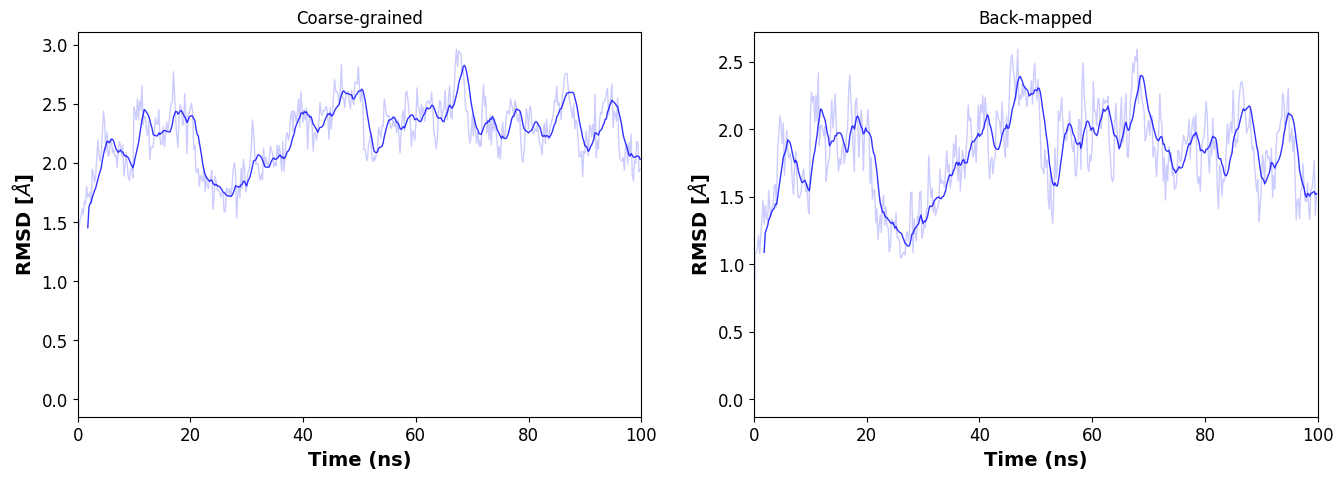

In [ ]:
#@title **Compute protein RMSD**
#@markdown **Provide output file names below:**
Output_name = 'rmsd' #@param {type:"string"}

nw_dcd = os.path.join(workDir, str(Jobname) + "_cg_nw.dcd")
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
traj_load_cg = pt.load(nw_dcd, nw_pdb)
traj_atomistic = os.path.join(workDir, str(Jobname) +  "_backmapped_align.dcd")
pdb_ref_atomistic = os.path.join(workDir, str(Jobname) +  "_backmapped_align.pdb")
traj_load_atomistic = pt.load(traj_atomistic, pdb_ref_atomistic)

ref_top = pt.load(pdb_ref_atomistic, pdb_ref_atomistic)
rmsd_cg = pt.rmsd(traj_load_cg, ref = 0)
df = pd.Series(rmsd_cg)
running_aver_cg = df.rolling(window =10).mean()
rmsd_atomistic = pt.rmsd(traj_load_atomistic, ref = 0, mask = "@CA,C,O,N,H")
df = pd.Series(rmsd_atomistic)
running_aver_atom = df.rolling(window =10).mean()


time = len(rmsd_cg)*int(Write_trajectory)/1000
time_array = np.arange(0,time,int(Write_trajectory)/1000)*int(stride_traj)

# Plotting:
fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
ax = plt.plot(time_array, rmsd_cg, alpha=0.2, color = 'blue', linewidth = 1.0)
ax = plt.plot(time_array, running_aver_cg, alpha=0.8, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
plt.title("Coarse-grained")
plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
ax = plt.plot(time_array, rmsd_atomistic, alpha=0.2, color = 'blue', linewidth = 1.0)
ax = plt.plot(time_array, running_aver_atom, alpha=0.8, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
plt.title("Back-mapped")
plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')
raw_data=pd.DataFrame(rmsd_cg)
raw_data.to_csv(os.path.join(workDir, Output_name + "_cg.csv"))
raw_data=pd.DataFrame(rmsd_atomistic)
raw_data.to_csv(os.path.join(workDir, Output_name + "_atomistic.csv"))

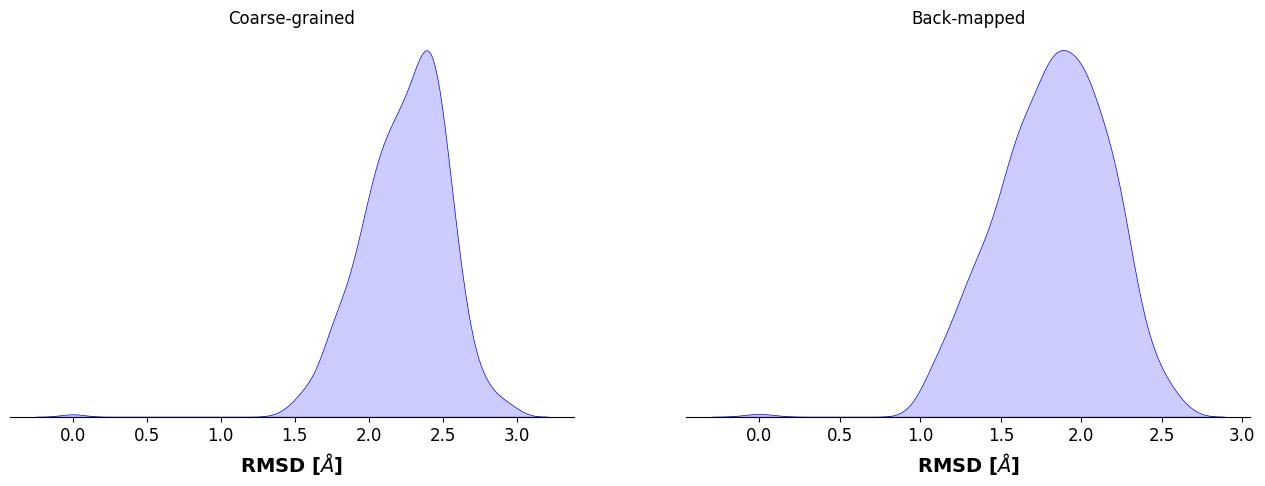

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}

fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
ax = sb.kdeplot(rmsd_cg, color="blue", fill=True, alpha=0.2, linewidth=0.5)
plt.title("Coarse-grained")
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.subplot(1, 2, 2)
ax = sb.kdeplot(rmsd_atomistic, color="blue", fill=True, alpha=0.2, linewidth=0.5)
plt.title("Back-mapped")
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

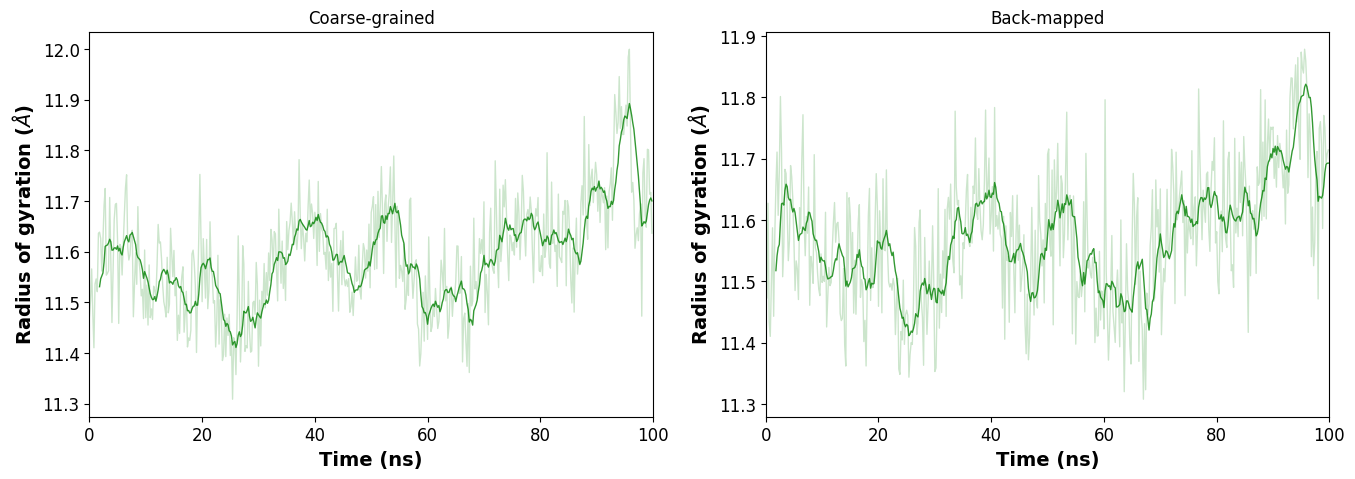

In [ ]:
#@title **Compute protein radius of gyration**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr_cg = pt.radgyr(traj_load_cg)
df = pd.Series(radgyr_cg)
running_aver_cg = df.rolling(window =10).mean()
radgyr_atom = pt.radgyr(traj_load_atomistic)
df = pd.Series(radgyr_atom)
running_aver_atom = df.rolling(window =10).mean()

time = len(running_aver_cg)*int(Write_trajectory)/1000
time_array = np.arange(0,time,int(Write_trajectory)/1000)*int(stride_traj)

# Plotting:
fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
plt.plot(time_array, radgyr_cg, alpha=0.2, color = 'green', linewidth = 1.0)
plt.plot(time_array, running_aver_cg, alpha=0.8, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
plt.title("Coarse-grained")
plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(time_array, radgyr_atom, alpha=0.2, color = 'green', linewidth = 1.0)
plt.plot(time_array, running_aver_atom, alpha=0.8, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
plt.title("Back-mapped")
plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')
raw_data=pd.DataFrame(radgyr_cg)
raw_data.to_csv(os.path.join(workDir, Output_name + "_cg.csv"))
raw_data=pd.DataFrame(radgyr_atom)
raw_data.to_csv(os.path.join(workDir, Output_name + "_atomistic.csv"))

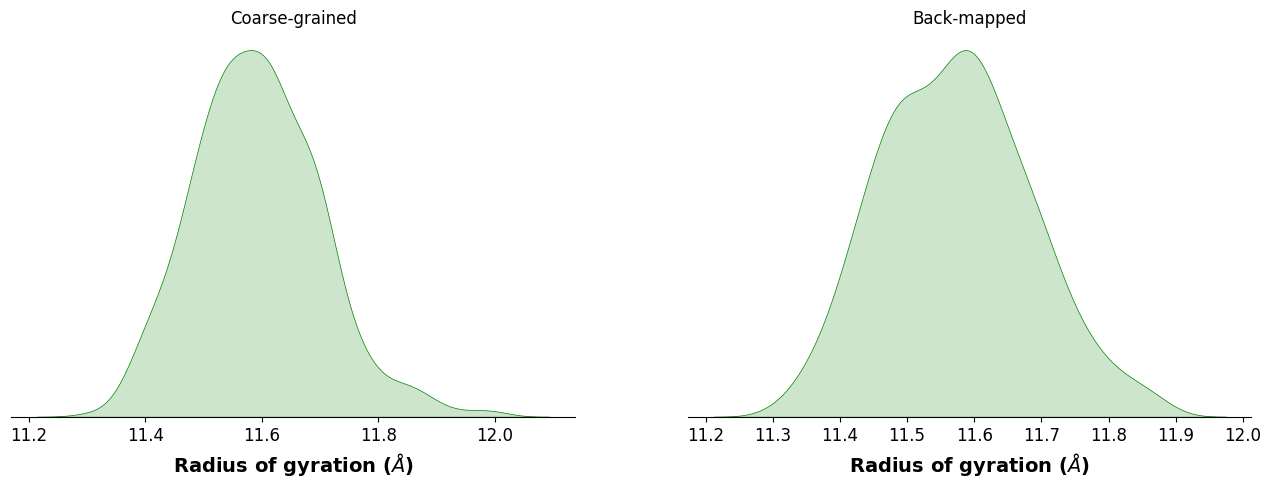

In [ ]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'radius_gyration_dist' #@param {type:"string"}


fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
ax = sb.kdeplot(radgyr_cg, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.title("Coarse-grained")
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.subplot(1, 2, 2)
ax = sb.kdeplot(radgyr_atom, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.title("Back-mapped")
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

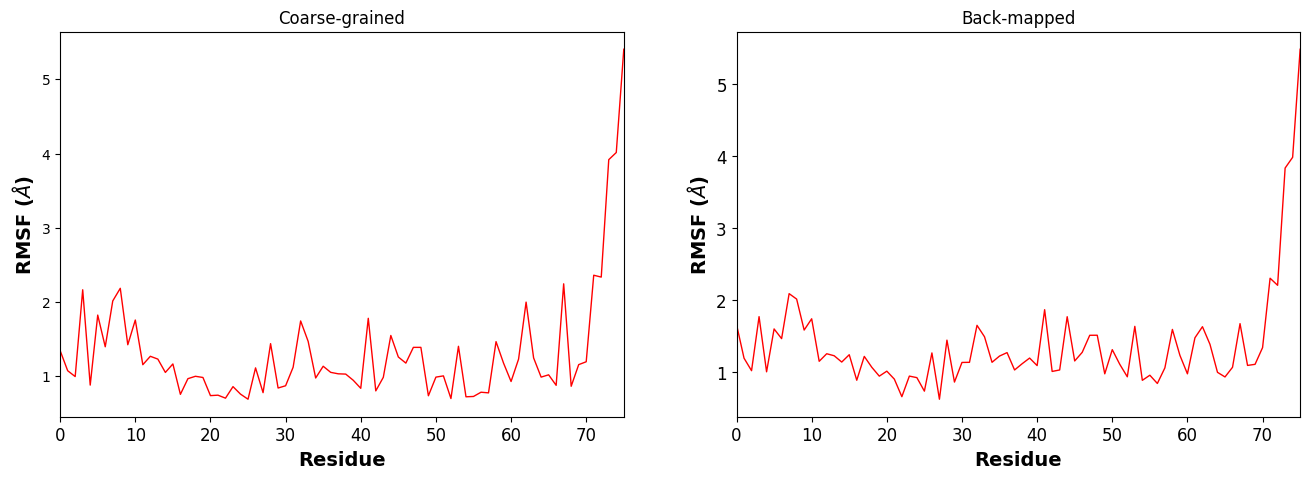

In [ ]:
#@title **Compute RMSF of protein**

#@markdown **Provide output file names below:**
Output_name = 'rmsf' #@param {type:"string"}


rmsf_cg = pt.rmsf(traj_load_cg, "byres")
# df = pd.Series(rmsf_cg[:,1])
# running_aver_cg = df.rolling(window =5).mean()
bfactor_cg = pt.bfactors(traj_load_cg, byres=False)
rmsf_atom = pt.rmsf(traj_load_atomistic,"byres")
bfactor_atom = pt.bfactors(traj_load_atomistic, byres=True)



# Plotting:
fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
plt.plot(rmsf_cg[:,1], alpha=1.0, color = 'red', linewidth = 1.0)
# plt.plot(running_aver_cg, alpha=1.0, color = 'red', linewidth = 1.0)
plt.title("Coarse-grained")
plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf_cg[:-1]))

plt.subplot(1, 2, 2)
plt.plot(rmsf_atom[:,1], alpha=1.0, color = 'red', linewidth = 1.0)
plt.title("Back-mapped")
plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf_atom[:-1]))

plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf_cg)
raw_data.to_csv(os.path.join(workDir, Output_name + "_cg.csv"))
raw_data=pd.DataFrame(rmsf_atom)
raw_data.to_csv(os.path.join(workDir, Output_name + "_atomistic.csv"))

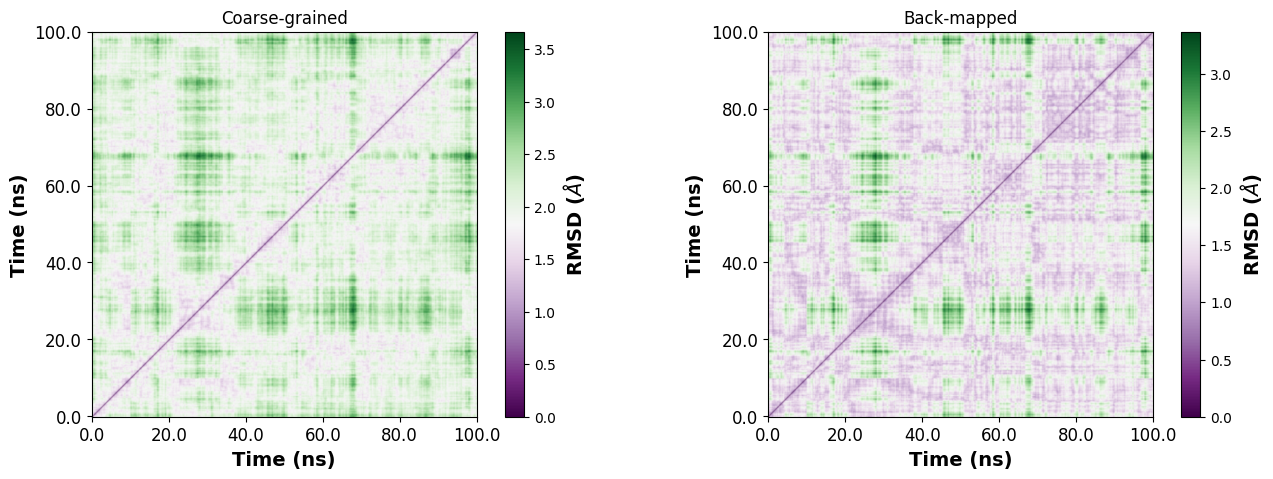

In [ ]:
#@title **2D RMSD**

#@markdown **Provide output file names below:**
Output_name = '2D_rmsd' #@param {type:"string"}

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

mat_cg = pt.pairwise_rmsd(traj_load_cg, frame_indices=range(int(number_frames_analysis)), metric="rms")
mat_atom = pt.pairwise_rmsd(traj_load_atomistic, mask = "@CA,C,O,N,H", frame_indices=range(int(number_frames_analysis)), metric="rms")

fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
ax = plt.imshow(mat_cg, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title("Coarse-grained")
plt.xlabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.xticks(a, b.round(decimals=3), fontsize = 12)
plt.yticks(a, b.round(decimals=3), fontsize = 12)
# plt.clim(0,3)
cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')


plt.subplot(1, 2, 2)
ax = plt.imshow(mat_atom, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title("Back-mapped")
plt.xlabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.xticks(a, b.round(decimals=3), fontsize = 12)
plt.yticks(a, b.round(decimals=3), fontsize = 12)
# plt.clim(0,3)
cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cg)
raw_data.to_csv(os.path.join(workDir, Output_name + "_cg.csv"))
raw_data=pd.DataFrame(mat_atom)
raw_data.to_csv(os.path.join(workDir, Output_name + "_atomistic.csv"))

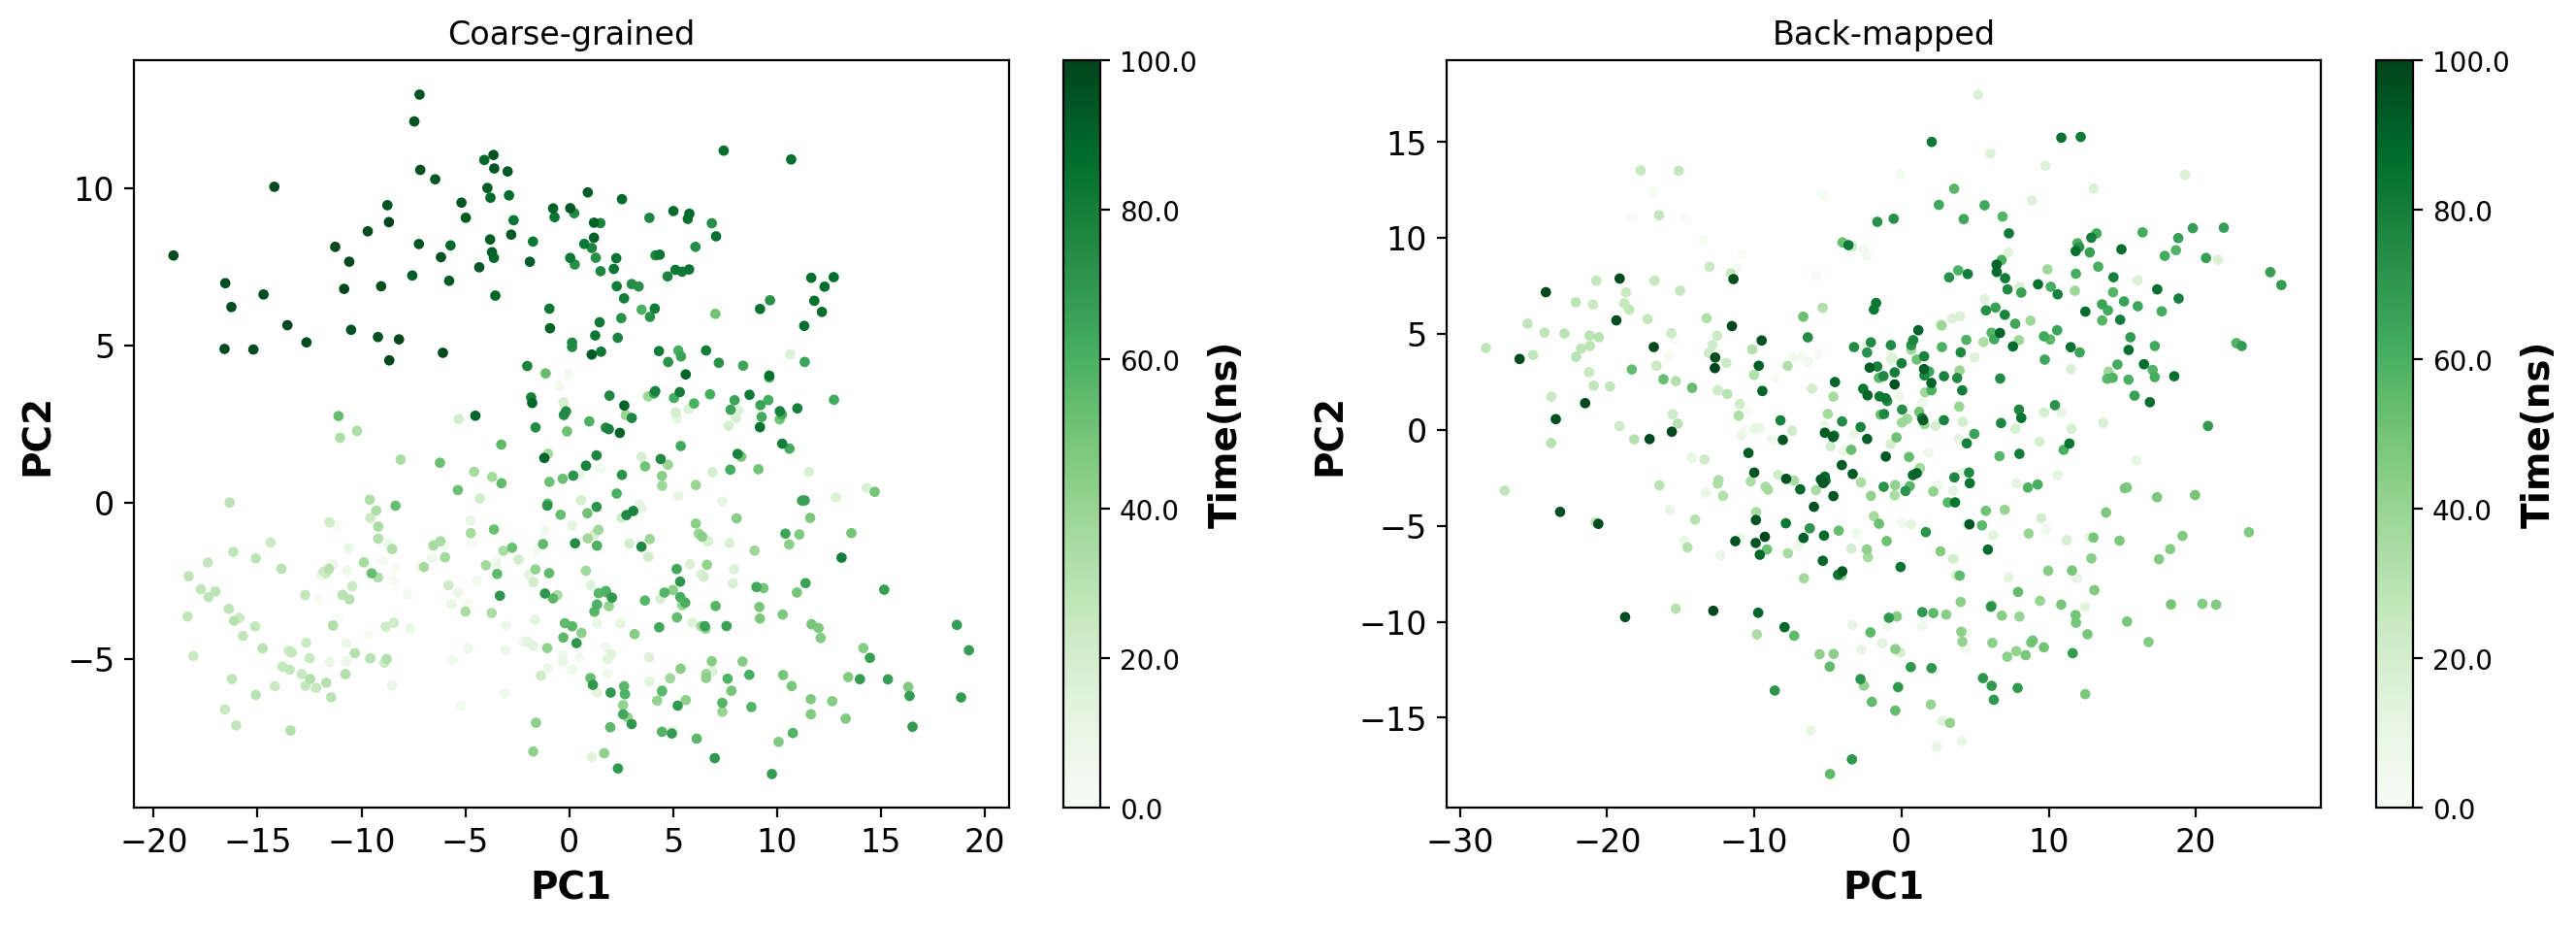

In [ ]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data_cg = pt.pca(traj_load_cg, fit=True, ref=0, mask='', n_vecs=2)
data_atom = pt.pca(traj_load_atomistic, fit=True, ref=0, mask = "@CA,C,O,N,H", n_vecs=2)


last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:**
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
projection_data = data_cg[0]
plt.title("Coarse-grained")
PC1_cg = data_cg[0][0]
PC2_cg = data_cg[0][1]
a = plt.scatter(PC1_cg,PC2_cg, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.subplot(1, 2, 2)
projection_data = data_atom[0]
plt.title("Back-mapped")
PC1_atom = data_atom[0][0]
PC2_atom = data_atom[0][1]
a = plt.scatter(PC1_atom,PC2_atom, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1_cg)
pc1.to_csv(os.path.join(workDir, Output_PC1 + "_cg.csv"))
pc2=pd.DataFrame(PC2_cg)
pc2.to_csv(os.path.join(workDir, Output_PC2 + "_cg.csv"))
pc1=pd.DataFrame(PC1_atom)
pc1.to_csv(os.path.join(workDir, Output_PC1 + "_atomistic.csv"))
pc2=pd.DataFrame(PC2_atom)
pc2.to_csv(os.path.join(workDir, Output_PC2 + "__atomistic.csv"))

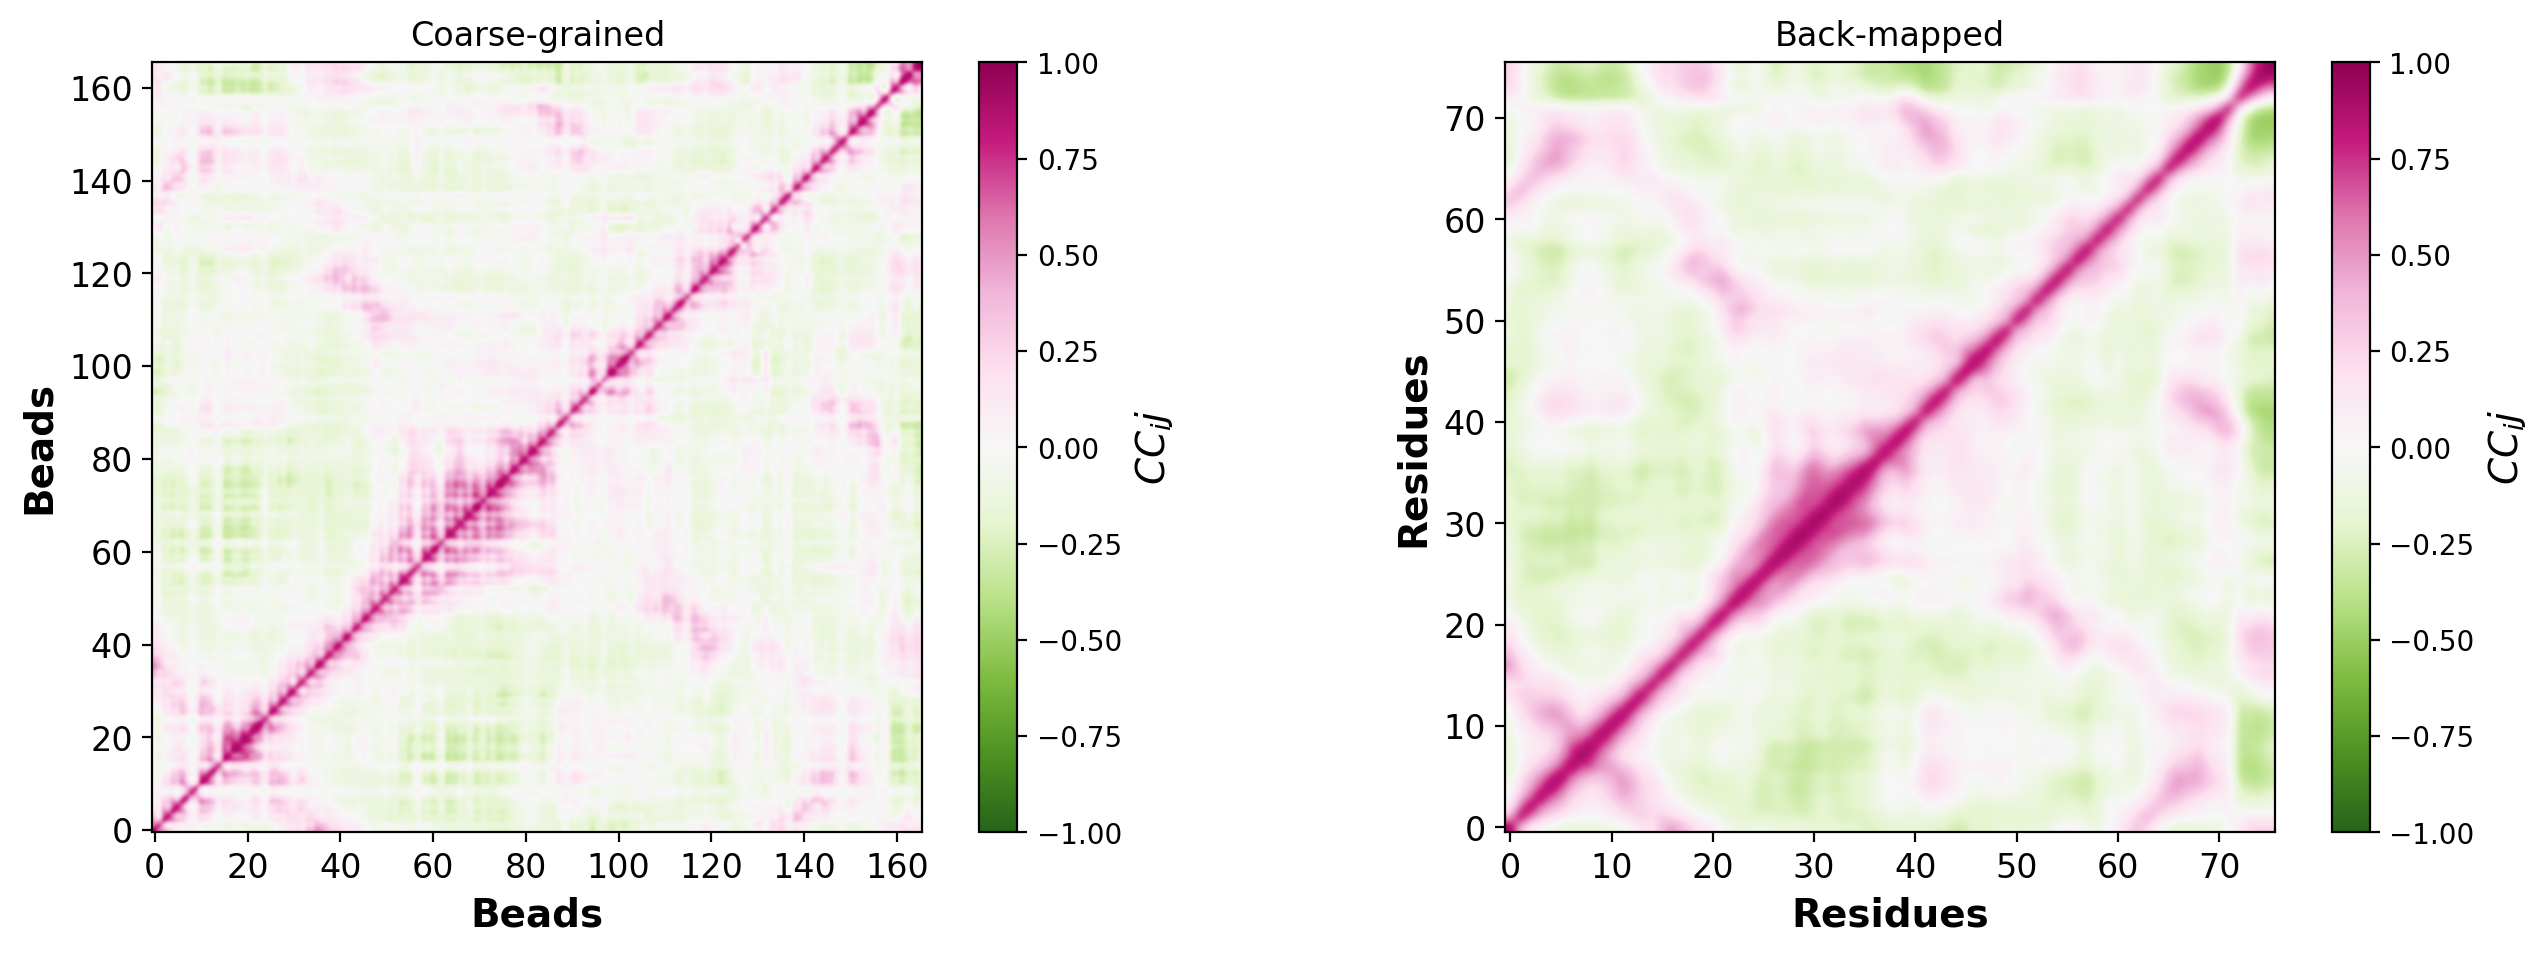

In [ ]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:**
Output_name = 'cross_correlation' #@param {type:"string"}

cc_cg = matrix.correl(traj_load_cg)
cc_atom = matrix.correl(traj_load_atomistic, '@CA')

fig, axs = plt.subplots(1, 2, figsize=(16, 5)) # Changed to 1 row, 2 columns
plt.subplot(1, 2, 1)
ax = plt.imshow(cc_cg, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')
plt.title("Coarse-grained")
plt.xlabel('Beads', fontsize = 14, fontweight = 'bold')
plt.ylabel('Beads', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.subplot(1, 2, 2)
ax = plt.imshow(cc_atom, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')
plt.title("Back-mapped")
plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(cc_cg)
raw_data.to_csv(os.path.join(workDir, Output_name + "_cg.csv"))
raw_data=pd.DataFrame(cc_atom)
raw_data.to_csv(os.path.join(workDir, Output_name + "_atomistic.csv"))